<a href="https://colab.research.google.com/github/sandun21/model-xai/blob/main/testing-notebooks/biLSTMcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240705%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240705T052952Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D10a94def13d5843adcc112fc19b1855871e7eeee918874ee89ca6e16ad3432ead614304227339a3df7cc5cdf3995ca11e5684f4c8495378bd74f3b3cc85b8c27449596974b7e30efb0d064a1065a261c76dea211257bb6f3f094170e58c04472272d71806150991569859694e6c41888f4bc7615c9af66072606482bbbb5193b34e66674adc51fe19aa4271cc3a2746b58722ffb76ebc72ac8d31c5ed10a1cc9e8e0e9dbaae74aae864f51ab358f7ea9990a0268a0c0152f5b4576ee429e740312d75f0124eb74ece07289413f5a7da5e983facfed0afe18af1ff6b1a69c9702be920775d5330dd85459997550751c0c820196fdc23041e4036ce122a3c03f3d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103633768 bytes downloaded
Downloaded and uncompressed: heartbeat
Data source import complete.


In [3]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=19ef815f04bf745dd9a77c36928a56553378faf6eb7fb2aa2dec91704f063ceb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
import tensorflow as tf

from lime import lime_tabular
import re

#### Loading the Dataset

In [5]:
#reading dataset
train_data = pd.read_csv("../input/heartbeat/mitbih_train.csv", header = None)
test_data = pd.read_csv("../input/heartbeat/mitbih_test.csv", header = None)

train_data[187] = train_data[187].astype('int')

### Experimenting with Dataset

list of classes : [0 1 2 3 4]


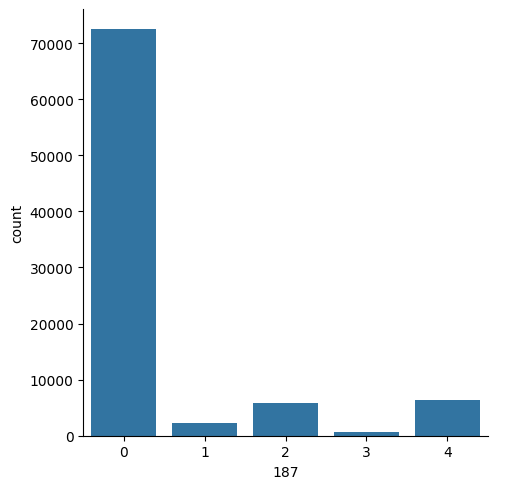

In [6]:
print("list of classes :",train_data.iloc[:, 187].unique())
sns.catplot(x = 187, kind = 'count', data = train_data)

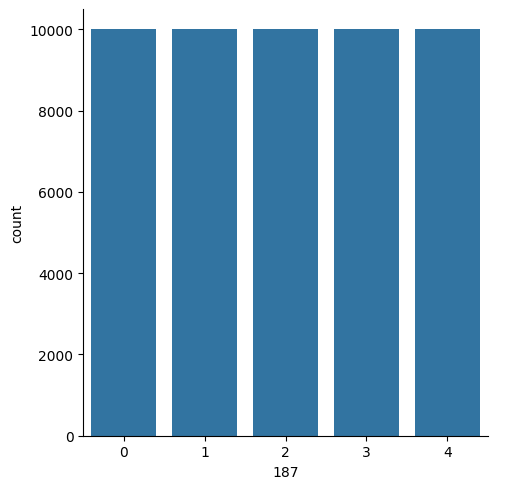

In [7]:
from sklearn.utils import resample

df_1 = resample(train_data[train_data[187] == 1], n_samples = 10000, replace = True, random_state = 123)
df_2 = resample(train_data[train_data[187] == 2], n_samples = 10000, replace = True, random_state = 123)
df_3 = resample(train_data[train_data[187] == 3], n_samples = 10000, replace = True, random_state = 123)
df_4 = resample(train_data[train_data[187] == 4], n_samples = 10000, replace = True, random_state = 123)

# downsample the high number of counts in one class, select random samples 2000 samples from class 0 samples
df_0 = train_data[train_data[187]==0].sample(n =10000, random_state=123)


train_df = pd.concat([df_0, df_1, df_2, df_3, df_4]).sample(frac=1, random_state=42).reset_index(drop=True)

sns.catplot(x = 187, kind = 'count', data = train_df)

In [8]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_df[187])
y_test  = to_categorical(test_data[187])

In [9]:
X_train = train_df.iloc[:, 1:187].values
X_test = test_data.iloc[:, 1:187].values

In [10]:
# For conv1D dimentionality should be 186 1 where 186 is number of features and 1 = 1D Dimentionality of data
X_train = X_train.reshape(len(X_train),X_train.shape[1],1)
X_test = X_test.reshape(len(X_test),X_test.shape[1],1)

## Model

In [11]:
from tensorflow.keras.layers import Conv1D, LSTM, MaxPooling1D, Flatten, Dense, BatchNormalization, Input, Bidirectional
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv1D(filters=64, kernel_size=20, activation='relu', padding='same', input_shape=(186, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding="same"),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),

    Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),

    Bidirectional(LSTM(32, activation="tanh")),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 186, 64)           448       
                                                                 
 batch_normalization (Batch  (None, 186, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 93, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 64)            12352     
                                                                 
 batch_normalization_1 (Bat  (None, 91, 64)            256       
 chNormalization)                                                
                                                        

In [12]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 59s 22ms/step - loss: 0.3190 - accuracy: 0.8830 - val_loss: 0.2550 - val_accuracy: 0.9138
Epoch 2/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.1472 - accuracy: 0.9471 - val_loss: 0.3360 - val_accuracy: 0.8823
Epoch 3/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.1013 - accuracy: 0.9645 - val_loss: 0.2089 - val_accuracy: 0.9244
Epoch 4/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0748 - accuracy: 0.9734 - val_loss: 0.1744 - val_accuracy: 0.9453
Epoch 5/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0635 - accuracy: 0.9782 - val_loss: 0.2165 - val_accuracy: 0.9329
Epoch 6/10
1563/1563 [==============================] - 28s 18ms/step - loss: 0.0514 - accuracy: 0.9823 - val_loss: 0.1616 - val_accuracy: 0.9471
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.0457 - accuracy: 0.9842 - val_loss: 0.2814 -

In [13]:
model.evaluate(X_test, y_test)

685/685 [==============================] - 5s 7ms/step - loss: 0.1706 - accuracy: 0.9501


[0.1706169992685318, 0.9501187801361084]

In [14]:
model.save("model.h5")# evaluate ECG Test Data


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

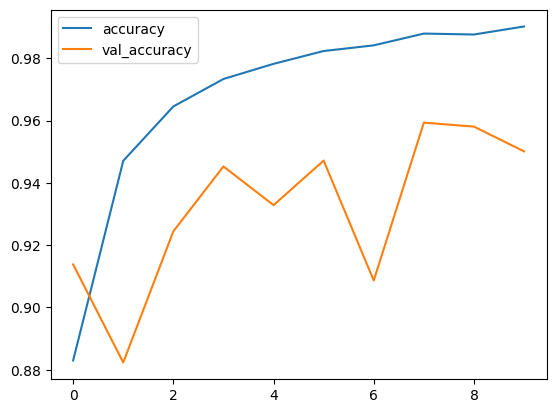

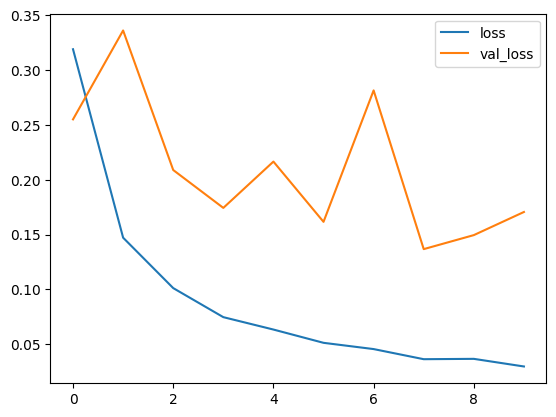

In [15]:
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

685/685 [==============================] - 5s 5ms/step


<Axes: >

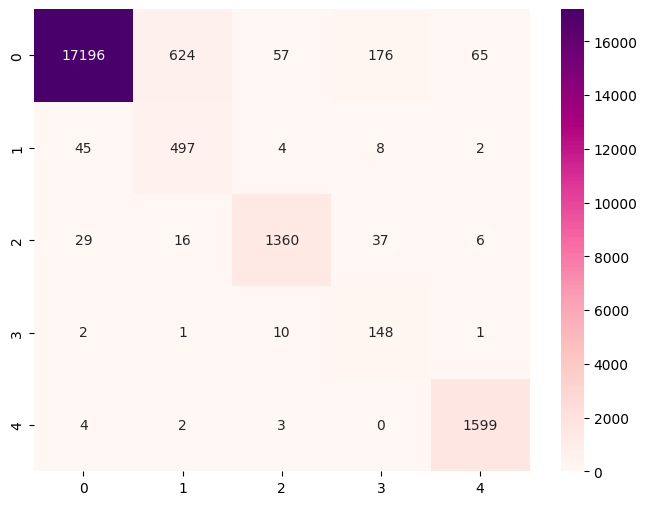

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# distributional probability to integers
yhat = np.argmax(model.predict(X_test), axis = 1)

confusion_matrix(np.argmax(y_test, axis = 1), yhat)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis =1), yhat), annot = True, fmt = '0.0f', cmap= 'RdPu')

## Intepreting with Lime

32/32 [==============================] - 0s 9ms/step
Intercept 0.0022979170778582147
Prediction_local [-0.00037443]
Right: 1.7251024e-11
Intercept 0.03276801455747422
Prediction_local [0.01769959]
Right: 2.2796771e-11
Intercept 1.2794950857910052
Prediction_local [1.10268868]
Right: 6.36832e-11
Intercept -0.1650424783112135
Prediction_local [-0.26597214]
Right: 1.573663e-10
Intercept -0.01285169302218871
Prediction_local [0.21112888]
Right: 1.0


<ipython-input-17-3e5b97ceaa93>:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Influence')


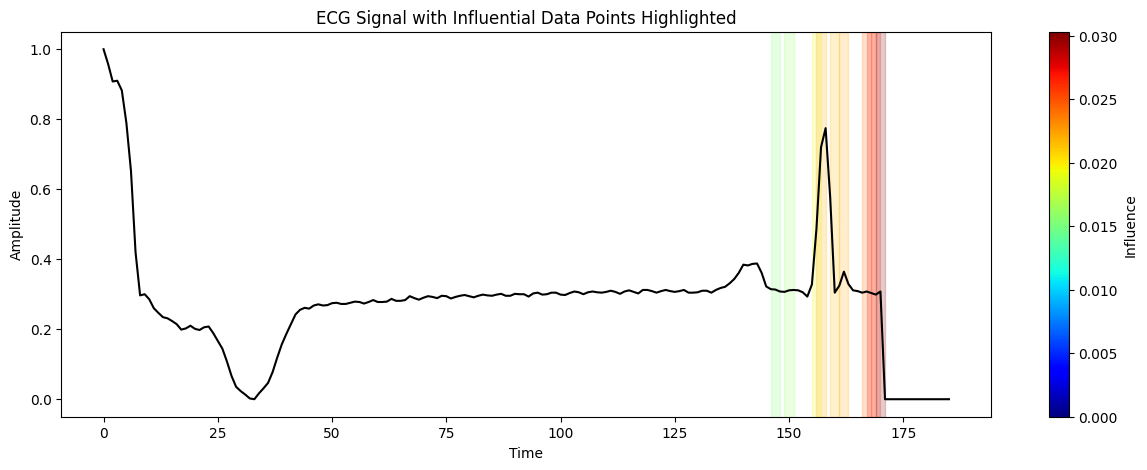

[0. 0. 1. 0. 0.]


In [17]:
# Select an instance to explain
z = 19142
instance = X_test[z].reshape(1, 186)

# Assuming model is already trained and X_test is defined
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.reshape(X_train.shape[0], -1),  # Flatten the input
    mode="classification",
    feature_names=[f"feature_{i}" for i in range(X_train.shape[1])],
    class_names=[str(i) for i in range(5)],
    verbose=True,
    random_state=42
)


# prediction function
predict_fn = lambda data: model.predict(data.reshape(-1, 186, 1))

explanation = explainer.explain_instance(instance[0], predict_fn, top_labels=5, num_features=10, num_samples=1000)

# Choose explainer for predicted disease
top_label = explanation.top_labels[0]
exp = explanation.as_list(label=top_label)

# Array with influencial values(scaled)
influence = np.zeros(instance.shape[1])

# Function to extract feature index from the feature string
def extract_feature_index(feature_str):
    # Find all numbers in the string
    numbers = re.findall(r'\d+', feature_str)
    if numbers:
        return int(numbers[0])  # Return the first number found
    else:
        raise ValueError(f"Could not find a number in the feature string: {feature_str}")

# Assign influence values to the corresponding points
for feature, weight in exp:
    feature_num = extract_feature_index(feature)
    influence[feature_num] = weight

# Normalize influence values for colormap
if np.max(influence) - np.min(influence) != 0:
    normalized_influence = (influence - np.min(influence)) / (np.max(influence) - np.min(influence))
else:
    normalized_influence = np.zeros(influence.shape)

# Plot the ECG signal with a background colored based on influence
plt.figure(figsize=(15, 5))
cmap = plt.get_cmap('jet')  # Use the 'jet' colormap for a similar effect

# Create horizontal gradient background
for i in range(len(instance[0])):
    if normalized_influence[i] > 0:  # Highlight areas with influence
        color = cmap(normalized_influence[i])
        plt.axvspan(i - 1, i + 1, color=color, alpha=0.2)  # Increase width and set higher transparency

# Plot the actual ECG signal in black for reference
plt.plot(range(len(instance[0])), instance[0], color='black')

plt.title('ECG Signal with Influential Data Points Highlighted')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Create a ScalarMappable and add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(influence), vmax=np.max(influence)))
sm.set_array([])
plt.colorbar(sm, label='Influence')

plt.show()

# Print the actual label for the instance
print(y_test[z])

32/32 [==============================] - 3s 8ms/step
Intercept -0.6267989779866286
Prediction_local [0.16612912]
Right: 9.541607e-06
Intercept 0.031688368563141174
Prediction_local [0.0098447]
Right: 1.8049413e-05
Intercept -0.0004560904098815737
Prediction_local [0.00113775]
Right: 0.0005181724
Intercept 1.6173465766383888
Prediction_local [0.82277395]
Right: 0.034208573
Intercept -0.01689480444705706
Prediction_local [0.03865389]
Right: 0.9652457


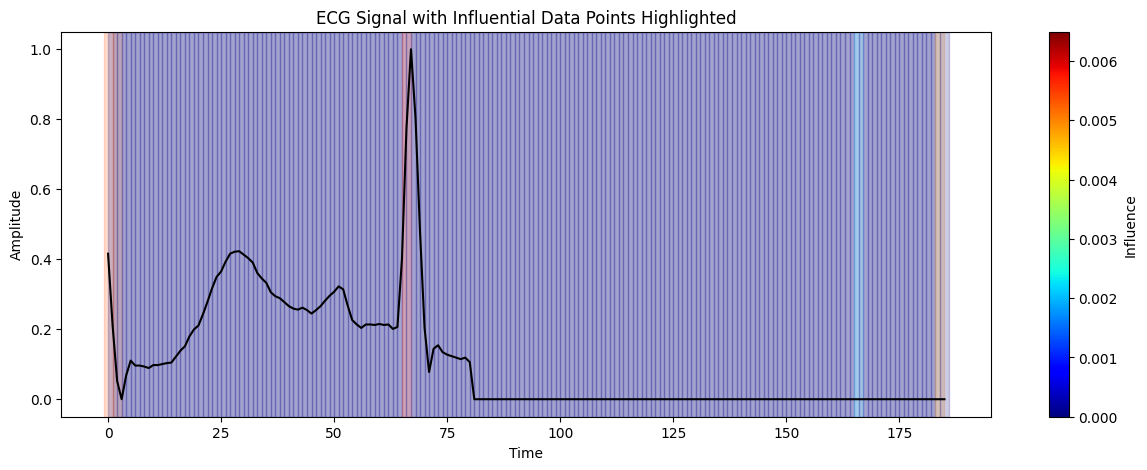

[0. 0. 1. 0. 0.]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import re
from lime import lime_tabular
from tensorflow.keras.models import load_model

# Assuming model is already trained and saved as model.h5
model = load_model("model.h5")

# Select an instance to explain
z = 18961
instance = X_train[z].reshape(1, 186)

# Create a LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.reshape(X_train.shape[0], -1),  # Flatten the input
    mode="classification",
    feature_names=[f"feature_{i}" for i in range(X_train.shape[1])],
    class_names=[str(i) for i in range(5)],
    verbose=True,
    random_state=42
)

# Prediction function
predict_fn = lambda data: model.predict(data.reshape(-1, 186, 1))

# Generate explanation
explanation = explainer.explain_instance(instance[0], predict_fn, top_labels=5, num_features=10, num_samples=1000)

# Choose explainer for predicted disease
top_label = explanation.top_labels[0]
exp = explanation.as_list(label=top_label)

# Array with influential values (scaled)
influence = np.zeros(instance.shape[1])

# Function to extract feature index from the feature string
def extract_feature_index(feature_str):
    # Find all numbers in the string
    numbers = re.findall(r'\d+', feature_str)
    if numbers:
        return int(numbers[0])  # Return the first number found
    else:
        raise ValueError(f"Could not find a number in the feature string: {feature_str}")

# Assign influence values to the corresponding points
for feature, weight in exp:
    feature_num = extract_feature_index(feature)
    influence[feature_num] = weight

# Normalize influence values for colormap
if np.max(influence) - np.min(influence) != 0:
    normalized_influence = (influence - np.min(influence)) / (np.max(influence) - np.min(influence))
else:
    normalized_influence = np.zeros(influence.shape)

# Plot the ECG signal with a background colored based on influence
fig, ax = plt.subplots(figsize=(15, 5))
cmap = plt.get_cmap('jet')

# Create horizontal gradient background for all points proportionally to their influence
for i in range(len(instance[0])):
    color = cmap(normalized_influence[i])
    ax.axvspan(i - 1, i + 1, color=color, alpha=0.2)  # Set higher transparency

# Plot the actual ECG signal in black for reference
ax.plot(range(len(instance[0])), instance[0], color='black')

ax.set_title('ECG Signal with Influential Data Points Highlighted')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# Create a ScalarMappable and add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(influence), vmax=np.max(influence)))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Influence')

plt.show()

# Print the actual label for the instance
print(y_test[z])
